In [1]:
# !pip install xgboost

import warnings
warnings.filterwarnings('ignore')

#General
from time import time
import pandas as pd
import seaborn as sns
import numpy as np
from time import time
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import Image
%matplotlib inline

from pathlib import Path
import pandas as pd
import pandas_profiling as pp
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
import numpy as np
from catboost import CatBoostClassifier, cv, Pool

#For encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#For feature importance:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot

#Estimators
from catboost import CatBoostClassifier, cv, Pool
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


# from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer

#Resampling
import imblearn
print(imblearn.__version__)
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler



# conda install -c conda-forge xgboost
# conda install -c conda-forge imbalanced-learn
# conda install -c glemaitre imbalanced-learn

#https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1
#https://towardsdatascience.com/multi-class-metrics-made-simple-the-kappa-score-aka-cohens-kappa-coefficient-bdea137af09c
# !pip install pandas --upgrade


0.2.1


## Class ReadData

- This class contains the following methods:
    - Read complete dataset: Read the final dataset
    - Get value user: Ask to the user to enter the target to evaluate
    - Identify features: which are numerical and which are categorical
    - Data imputation: Fill in missing values
    - Factorize cat: Encode target as ordinal
    - Calc smooth mean: target encoding techique using smoothing. Encode all the variables different from the target
    - Describe data: Generates EDA for the dataset using pandas profiling

In [2]:
class ReadData:
    def __init__(self, data_crashes, data_people, data_vehicle, drop_cols):
#         self.crashes = data_crashes
#         self.people = data_people
#         self.vehicle = data_vehicle
#         self.drop_col = drop_cols
        self.path = 'C:/Users/Cristina/Documents/GWU/Capstone/Data/'
#         self.path ='C:/Users/mariagi/Documents/Borrar/'

    def read_dataset(self):
        """Read files and Join the data in one file"""
        self.crashes = pd.read_csv(self.path + self.crashes, dtype='unicode')
        self.people = pd.read_csv(self.path  + self.people, dtype='unicode')
        self.vehicle = pd.read_csv(self.path + self.vehicle, dtype='unicode')
        self.drop_col = list(pd.read_csv(str(self.path + self.drop_col)))
        df = self.join_data()    
        return df
    
    def read_complete_data(self):
        """for a faster reading, read the final file with the joins"""
        df = pd.read_csv(self.path + 'Merged_New_Variables_Only.csv')#, dtype='unicode')
        
        df = df.drop(['CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE', 'LATITUDE', 'LONGITUDE'], axis =1) #'CRASH_DATE_x', 'DATE_POLICE_NOTIFIED', 'HIT_AND_RUN_I', 'RD_NO_y', 
        return df

    def join_data(self):
        """Join people, crashes and vehicles dataset"""
        df = self.crashes.merge(self.people, on='CRASH_RECORD_ID').merge(self.vehicle, on=['CRASH_RECORD_ID', 'VEHICLE_ID'])
        df = df.drop(self.drop_col, axis=1)  # Drops columns according to excel
        df = self.delete_rows(df)
        
        """Create a full dataset after join"""
#         df.to_csv(r'C:/Users/Cristina/Documents/GWU/Capstone/Data/final_accidents_complete.csv')
        df.to_csv(r'C:/Users/Cristina/Documents/GWU/Capstone/Data/final_accidents2.csv')
        return df
    
    def get_value_user(self, df):
        #ask to the user to enter which target wants to evaluate
        while True:
            try:
                target = input("Enter TARGET to evaluate: ")
            except ValueError:
                print("Please, enter a value")
                continue

            if target == 'DAMAGE':
                df = df.drop(['CRASH_TYPE', 'Most_Severe_Injury_New' ], axis =1)
                break
            elif target == 'CRASH_TYPE':
                df = df.drop(['DAMAGE', 'Most_Severe_Injury_New' ], axis =1)
                break
            elif target =='Most_Severe_Injury_New':
                df = df.drop(['CRASH_TYPE', 'CRASH_TYPE' ], axis =1)
                break
            else:
                print("Invalid! ", target)
                continue
        return df
   
    
    def convert_datetime(self, df):
        df.CRASH_DATE = pd.to_datetime(df.CRASH_DATE)
        return df
    
    def convert_categorical(self,df):
        cols = df.select_dtypes(exclude = ['int64', 'float64', 'datetime']).columns.to_list()
        df[cols] = df[cols].astype('category')
        return df
      
    
    def identify_features(self, df):
        """Identify categorical and numerical features"""
        cols= df.select_dtypes(exclude=['int64', 'float64', 'datetime']).columns.to_list()
        df[cols]=df[cols].astype('category')
        
        numerical_index = df.select_dtypes(include=['int64', 'float64']).columns
        categorical_index = df.select_dtypes(include=['object', 'bool', 'category']).columns
        return numerical_index, categorical_index
    
    def data_imputation(self, df):        
        #categorical
        df["Traffic_Control_New"].fillna((df["Traffic_Control_New"].mode()[0]), inplace=True)
        df["Road_Surface_New"].fillna((df["Road_Surface_New"].mode()[0]), inplace=True)
        df["SEX2"].fillna((df["SEX2"].mode()[0]), inplace=True)        
        df['Weather_New'].fillna((df.groupby(['Road_Surface_New'])['Weather_New'].transform(lambda x: x.mode()[0])), inplace = True)
        
        #numerical
        df["Posted_Speed_New"].fillna((df["Posted_Speed_New"].mean()), inplace=True)
        df["BAC2"].fillna((df["BAC2"].mean()), inplace=True)
        df["AGE2"].fillna((df.groupby('SEX2')["AGE2"].transform("median")), inplace = True)
        return df
    
    
    def factorize_categ(self, df, target):
        """Ordinal Encoding just for target"""
        le = LabelEncoder()
        df[target] = le.fit_transform(df[target])
#         print(le.classes_)
        return df, le

    def calc_smooth_mean(self, df, by, on, m):
        """target encoding techique using smoothing. It is used to encode all the variables different from the target"""
        # Compute the global mean
        mean = df[on].mean()
        # Compute the number of values and the mean of each group
        agg = df.groupby(by)[on].agg(['count', 'mean'])
        counts = agg['count']
        means = agg['mean']
        # Compute the "smoothed" means
        smooth = (counts * means + m * mean) / (counts + m)
        # Replace each value by the according smoothed mean
        return df[by].map(smooth)
    

    def describe_data(self, df):
        return ProfileReport(df, title='Pandas Profiling Report', html={'style':{'full_width':True}})

    

## Class Training

- This class contains the following methods:
    - Split data
    - Feature importance using trees
    - Feature importance using logistic regression
    - Oversampling: using SMOTE to be used in shallow models
    - Oversampling: using random oversampling to be used in CatBoost
    - Model catboost: Train and predict using CatBoost
    - Classifiers: Shallow models
    - Model selection: Selects the best model from classifiers
    - Predict: Predicts according to the best model (Model selection)

In [3]:
class Training(ReadData):
    
    def __init__(self):
#         self.file1 = "Traffic_Crashes_-_Crashes.csv"
#         self.file2 = "Traffic_Crashes_-_People.csv"
#         self.file3 = "Traffic_Crashes_-_Vehicles.csv"
#         self.path = 'C:/Users/mariagi/Documents/Borrar/'
        self.path = 'C:/Users/Cristina/Documents/GWU/Capstone/Data/'
#         self.df = ReadData(self.file1, self.file2, self.file3, "drop_cols.csv")
    
    def split_data(self, df, target):
        
        X = df.drop([target], axis=1)
        y = df[target]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)             
        
        print(X.dtypes)
        categorical_features_indices = np.where(X.dtypes != np.float)[0]
        return X, y, X_train, X_test, y_train, y_test, categorical_features_indices
    
    def feature_importance(self, X, y):
        col = X.columns

        # Build a forest and compute the feature importances
        forest = ExtraTreesClassifier(n_estimators=250, random_state=0)

        forest.fit(X, y)
        importances = forest.feature_importances_
        indices = np.argsort(importances)[::-1]
        std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                     axis=0)

        colNew = []

        for f in range(X.shape[1]):
            ind = indices[f]
            colNew.append(col[ind])

        # Plot the feature importances of the forest
        plt.figure(figsize=(10,8))
        plt.title("Feature Importances")
        plt.barh(range(X.shape[1]), importances[indices], tick_label=colNew, color="r", yerr=std[indices], align="center")
        plt.tight_layout()
        plt.savefig('feature_importance.png')
        plt.show()
        
    def feature_importance_lr(self, X, y):
        # define the model
        model = LinearRegression()
        # fit the model
        model.fit(X, y)
        # get importance
        importance = model.coef_
        print(np.argsort(importance))
        # summarize feature importance
        for i,v in enumerate(importance):
            print('Feature: %0d, Score: %.5f' % (i,v))
        # plot feature importance
        pyplot.bar([x for x in range(len(importance))], importance)
        pyplot.show()
        print(list(X.columns))
    
    def oversampling(self, X_train, y_train):
        sm = SMOTE(random_state=12)
        X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
        return X_train_res, y_train_res
    
    def oversampling_cat(self, X_train, y_train):
        # import the Random Over Sampler object.
        from imblearn.over_sampling import RandomOverSampler
         # create the object.
        over_sampler = RandomOverSampler()
        # fit the object to the training data.
        X_train_res, y_train_res = over_sampler.fit_sample(X_train, y_train)
        print('Resampled dataset shape %s' % Counter(y_train_res))
        return X_train_res, y_train_res
    

    def model_catboost(self, X,y, X_train, y_train, X_test, y_test, categorical_features_indices, target, file):
       
        from sklearn import metrics
        from catboost.utils import get_confusion_matrix
        import matplotlib.pyplot as plt
        import seaborn as sns
        import warnings
        warnings.filterwarnings("ignore")
        plt.style.use('ggplot')
        
         #Adicione esto: inicio
        train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
        validate_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)
        #fin
        
        
#         model=CatBoostClassifier(loss_function='MultiClass',use_best_model=True, random_seed=42)#, class_weights=[1,2,3,4,5,6,7,8,9,10,11])
        model=CatBoostClassifier(loss_function='MultiClass',eval_metric='TotalF1', use_best_model=True, random_seed=42, 
                                 leaf_estimation_method='Newton')#, iterations=100)#, class_weights=[1,2,3,4,5,6,7,8,9,10,11])
        
        #Adicione esto: inicio
        model.fit(train_pool, eval_set=validate_pool, use_best_model=True, verbose=50, plot=True, early_stopping_rounds=100)
        #fin

        
        #cross-validation
        cv_params = model.get_params()
        cv_data = cv(Pool(X, y, cat_features=categorical_features_indices), cv_params, fold_count=10, plot=True)
        print('Precise validation accuracy score: {}'.format(np.max(cv_data)))#['TotalF1']
        #fin
        
        
        print("PRIMER prediccion")
        print(); print(model)
        # make predictions
        expected_y  = y_test
        predicted_y = model.predict(X_test)
        # summarize the fit of the model
        print(); print(metrics.classification_report(expected_y, predicted_y))
        print(); print(metrics.confusion_matrix(expected_y, predicted_y))

        
        print("SEGUNDO prediccion")
        print(model.best_iteration_, model.best_score_)
        print(model.evals_result_['validation_1']['MultiClass'][-10:])
        
        #prediction
        pred = model.predict(X_test)
        print("PREDICT")
        print(pred)
        
        print("print dataframe predictions:")
        cm = pd.DataFrame()
#         cm['DAMAGE'] = y_test
        cm[target] = y_test
        cm['Predict'] = model.predict(X_test)
        print(cm)
        
        print("SCORES")
        print(model.score(X_test, y_test))
        cm.to_csv(file)#, index=False)
#         cm.to_csv("catboost_prediction.csv")#, index=False)
        
        #confusion matrix
        print("confusion matrix:")
#         conf_mat = get_confusion_matrix(model, Pool(X_train, y_train, cat_features=categorical_features_indices))
        conf_mat = get_confusion_matrix(model, Pool(X_test, y_test, cat_features=categorical_features_indices))
        print(conf_mat)
        
        return model, cv_data
    
   
    def classifiers(self, X_train, X_test, y_train, y_test, df, target):

        #model SElection *********
        from sklearn.metrics import accuracy_score, log_loss
        from sklearn.neighbors import KNeighborsClassifier
        from sklearn.svm import SVC, LinearSVC, NuSVC
        from sklearn.tree import DecisionTreeClassifier
        from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
        from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
        from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
        from sklearn.metrics import classification_report

        t0 = time()
        param_grids = {}
        best_score_param_estimators=[]
        classifiers = [
            LogisticRegression(random_state=0),
            KNeighborsClassifier(3),
            DecisionTreeClassifier(class_weight='balanced'),
            RandomForestClassifier(class_weight='balanced'),
            AdaBoostClassifier(),
            GradientBoostingClassifier(),
            XGBClassifier(),
#             SVC(kernel="rbf", C=0.025, probability=True),
#             NuSVC(probability=True),
            ]
#         for classifier in classifiers:
#             pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifier)])
#             pipe.fit(X_train, y_train)   
#             print(classifier)
#             print("model score: %.3f" % pipe.score(X_test, y_test))
# #             print(classification_report(y_test, y_prediction))

 # For each classifier
        for classifier in classifiers:
            # GridSearchCV
            gs = GridSearchCV(estimator=Pipeline([('StandardScaler', StandardScaler()), ('classifier', classifier)]),
                              param_grid=param_grids,#[name],
                              scoring='f1_micro',#'accuracy',
                              n_jobs=1,
                              iid=False,
                              cv=StratifiedKFold(n_splits=5,
                                                 shuffle=True,
                                                 random_state=0))
            # Fit the pipeline
            gs = gs.fit(X_train, y_train)
            print('1')
            
            best_score_param_estimators.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
        
        print("done in %0.3fs" % (time() - t0))#returns time it takes to run
        return best_score_param_estimators


    def classifiers3(self, X_train, y_train): #X_validation, y_validation, df, target):
        
        t0 = time()
       
        clfs = {#'lr': LogisticRegression(random_state=0),
#                 'mlp': MLPClassifier(random_state=0),
#                 'dt': DecisionTreeClassifier(random_state=0),
#                 'rf': RandomForestClassifier(random_state=0),
#                 'xgb': XGBClassifier(seed=0),
                'svc': SVC(random_state=0),
                'knn': KNeighborsClassifier(),
                'gnb': GaussianNB()}
        

        pipe_clfs = {}

        for name, clf in clfs.items():
            # Implement me
            pipe_clfs[name] = Pipeline([('StandardScaler', StandardScaler()), 
                                        ('clf', clf)])
        print(pipe_clfs['gnb'])
        
        param_grids = {}
        
        ##LR
#         C_range = [10 ** i for i in range(-4, 5)]

#         param_grid = [{'clf__multi_class': ['ovr'], 
#                        'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#                        'clf__C': C_range},

#                       {'clf__multi_class': ['multinomial'],
#                        'clf__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
#                        'clf__C': C_range}]

#         param_grids['lr'] = param_grid
        
#         ###MLP
#         param_grid = [{'clf__hidden_layer_sizes': [10, 100],
#                'clf__activation': ['identity', 'logistic', 'tanh', 'relu']}]

#         param_grids['mlp'] = param_grid
        
#         ##DT
#         param_grid = [{'clf__min_samples_split': [2, 10, 30],
#                'clf__min_samples_leaf': [1, 10, 30]}]

#         param_grids['dt'] = param_grid
        
#         ##RF
#         param_grid = [{'clf__n_estimators': [10, 100],
#                'clf__min_samples_split': [2, 10, 30],
#                'clf__min_samples_leaf': [1, 10, 30]}]

#         param_grids['rf'] = param_grid
        
#         ##XGBOOST
#         param_grid = [{'clf__eta': [10 ** i for i in range(-4, 1)],
#                'clf__gamma': [0, 10, 100],
#                'clf__lambda': [10 ** i for i in range(-4, 5)]}]

#         param_grids['xgb'] = param_grid
        
        ##SVC
        param_grid = [{'clf__C': [10 ** i for i in range(-4, 5)],
               'clf__gamma': ['auto', 'scale']}]

        param_grids['svc'] = param_grid
        
        ##KNN
        param_grid = [{'clf__n_neighbors': list(range(1, 11))}]

        param_grids['knn'] = param_grid
        
        ##GNB
        param_grid = [{'clf__var_smoothing': [10 ** i for i in range(-10, -7)]}]

        param_grids['gnb'] = param_grid

        print(param_grids)
        
        ####Hyperparameter tuning
        # The list of [best_score_, best_params_, best_estimator_]
        best_score_param_estimators = []

        # For each classifier
        for name in pipe_clfs.keys():
            # GridSearchCV
            gs = GridSearchCV(estimator=pipe_clfs[name],
                              param_grid=param_grids[name],
                              scoring='accuracy',
                              n_jobs=1,
                              iid=False,
                              cv=StratifiedKFold(n_splits=5,
                                                 shuffle=True,
                                                 random_state=0))
            # Fit the pipeline
            gs = gs.fit(X_train, y_train)
            print('1')


            # Update best_score_param_estimators
            best_score_param_estimators.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
        
        print("done in %0.3fs" % (time() - t0))#returns time it takes to run
        return best_score_param_estimators
    
    def model_selection(self, best_score_param_estimators):
        # Sort best_score_param_estimators in descending order of the best_score_
        best_score_param_estimators = sorted(best_score_param_estimators, key=lambda x : x[0], reverse=True)

        # Print best_score_param_estimators
        for rank in range(len(best_score_param_estimators)):
            best_score, best_params, best_estimator = best_score_param_estimators[rank]

            print('Top', str(rank + 1))    
            print('%-15s' % 'best_score:', best_score)
#             print('%-15s' % 'best_estimator:'.format(20), type(best_estimator.named_steps['clf']))
            print('%-15s' % 'best_estimator:'.format(20), type(best_estimator.named_steps['']))
            print('%-15s' % 'best_params:'.format(20), best_params, end='\n\n')

        # Get the best estimator
        best_estimator = best_score_param_estimators[0][2]
        return best_estimator
    
    def predict(self, best_estimator, X_test, y_test, le):
    
        # Predict the target value using the best estimator
        print("Predicting DISBURSMENT CLASS on the test set")
        t0 = time()
        expected_y  = y_test
        y_pred = best_estimator.predict(X_test)
        
        #gets the original target
        y_pred = le.inverse_transform(y_pred)
        expected_y = le.inverse_transform(expected_y)
        
        #returns time it takes to run
        print("done in %0.3fs" % (time() - t0))

        print(); print(classification_report(expected_y, y_pred))
        print(); print(confusion_matrix(expected_y, y_pred))
    

In [4]:
# file1 = "Traffic_Crashes_-_Crashes.csv"
# file2 = "Traffic_Crashes_-_People.csv"
# file3 = "Traffic_Crashes_-_Vehicles.csv"

mt = Training()
df = mt.read_complete_data()
# df = mt.convert_categorical(df)
df = mt.data_imputation(df)
df.isnull().sum()

PRIM_CONTRIBUTORY_CAUSE    0
CRASH_TYPE                 0
FIRST_CRASH_TYPE           0
DAMAGE                     0
NUM_UNITS                  0
CRASH_HOUR                 0
CRASH_DAY_OF_WEEK          0
CRASH_MONTH                0
Contributory_Cause_New     0
Posted_Speed_New           0
Traffic_Control_New        0
Weather_New                0
Road_Surface_New           0
Most_Severe_Injury_New     0
SEX2                       0
BAC2                       0
AGE2                       0
dtype: int64

## EDA
- Generates EDA for the dataset. It should be executed when needed. It takes long to process

In [ ]:
profile = crash.describe_data(df_crashes)
profile.to_file("C:/Users/mariagi/Documents/Borrar/EDA2_accidents2_withoutMV.html")

## Enter target to evaluate

- Since there are threee possible targets: DAMAGE, CRASH_TYPE and Most_Severe_Injury_New. It is necessary that the user enters the target to evaluate
    - the target has to be enter in the same way that it is in the file

In [5]:
df = mt.get_value_user(df)

## Encode features

- Encoding is necessary to run shallow models
    - Target: Ordinal Encoding
    - Features: Targeting encoding using smoothing

In [6]:
#ENCODE VARIABLES (FACTORIZE: ORDINAL (TARGET) - ENCODE TARGET TECHNIQUE USING SMOOTH: OTHER VABLES)
target = 'CRASH_TYPE'
df_encoded, le = mt.factorize_categ(df, target=target)

df_encoded['PRIM_CONTRIBUTORY_CAUSE'] = mt.calc_smooth_mean(df_encoded, by='PRIM_CONTRIBUTORY_CAUSE', on=target, m=10)
df_encoded['FIRST_CRASH_TYPE'] = mt.calc_smooth_mean(df_encoded, by='FIRST_CRASH_TYPE', on=target, m=10)
df_encoded['Contributory_Cause_New'] = mt.calc_smooth_mean(df_encoded, by='Contributory_Cause_New', on=target, m=10)
df_encoded['Traffic_Control_New'] = mt.calc_smooth_mean(df_encoded, by='Traffic_Control_New', on=target, m=10)
df_encoded['Weather_New'] = mt.calc_smooth_mean(df_encoded, by='Weather_New', on=target, m=10)
df_encoded['Road_Surface_New'] = mt.calc_smooth_mean(df_encoded, by='Road_Surface_New', on=target, m=10)
df_encoded['SEX2'] = mt.calc_smooth_mean(df_encoded, by='SEX2', on=target, m=10)


df_encoded.isna().any()

PRIM_CONTRIBUTORY_CAUSE    False
CRASH_TYPE                 False
FIRST_CRASH_TYPE           False
NUM_UNITS                  False
CRASH_HOUR                 False
CRASH_DAY_OF_WEEK          False
CRASH_MONTH                False
Contributory_Cause_New     False
Posted_Speed_New           False
Traffic_Control_New        False
Weather_New                False
Road_Surface_New           False
SEX2                       False
BAC2                       False
AGE2                       False
dtype: bool

## Shallow Models

- Splits the data in training and test 
- Since our labesl are imbalanced. Oversampling is performed 
- Training is performed 

In [ ]:
%%time
# # ENCODED: SPLIT IN TRAINING AND TEST 
X, y, X_train, X_validation, y_train, y_validation, categorical_features_indices = mt.split_data(df_encoded, target=target)
# # print(X_train.head())
# # print(X_train.isna().any())

# OVERSAMPLING
X_train_res, y_train_res = mt.oversampling(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train_res))

# from imblearn.over_sampling import SMOTENC
# sm = SMOTENC(categorical_features_indices, random_state=42)
# X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

# # print(X_train_res.isna().any())
# # print(X_train_res.head())
# # X_train.isnull().sum()
# X_train_res.isnull().sum()
# # y_train_res.isnull().sum()


#SHALLOW CLASSIFIERS-OVERSAMPLED
best_score_param_estimators = mt.classifiers3(X_train_res, y_train_res)#,  X_validation, y_train_res, df_encoded, target='Disb Class')

# # # df_encoded.isnull().sum()

Resampled dataset shape Counter({1: 193881, 0: 193881})
Pipeline(memory=None,
         steps=[('StandardScaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf', GaussianNB(priors=None, var_smoothing=1e-09))],
         verbose=False)
{'svc': [{'clf__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'clf__gamma': ['auto', 'scale']}], 'knn': [{'clf__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}], 'gnb': [{'clf__var_smoothing': [1e-10, 1e-09, 1e-08]}]}


In [7]:
%%time
# # ENCODED: SPLIT IN TRAINING AND TEST 
X, y, X_train, X_validation, y_train, y_validation, categorical_features_indices = mt.split_data(df_encoded, target=target)
# OVERSAMPLING
X_train_res, y_train_res = mt.oversampling(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train_res))
best_score_param_estimators=mt.classifiers(X_train_res, X_validation, y_train_res, y_validation, df_encoded, target=target)

PRIM_CONTRIBUTORY_CAUSE    float64
FIRST_CRASH_TYPE           float64
NUM_UNITS                    int64
CRASH_HOUR                   int64
CRASH_DAY_OF_WEEK            int64
CRASH_MONTH                  int64
Contributory_Cause_New     float64
Posted_Speed_New           float64
Traffic_Control_New        float64
Weather_New                float64
Road_Surface_New           float64
SEX2                       float64
BAC2                       float64
AGE2                       float64
dtype: object
Resampled dataset shape Counter({1: 193881, 0: 193881})
1
1
1
1
1
1
1
done in 5672.425s
Wall time: 1h 34min 42s


In [8]:
%%time
# best_estimator = mt.model_selection(best_score_param_estimators)
best_score_param_estimators = sorted(best_score_param_estimators, key=lambda x : x[0], reverse=True)

# Print best_score_param_estimators
for rank in range(len(best_score_param_estimators)):
    best_score, best_params, best_estimator = best_score_param_estimators[rank]

    print('Top', str(rank + 1))    
    print('%-15s' % 'best_score:', best_score)
#             print('%-15s' % 'best_estimator:'.format(20), type(best_estimator.named_steps['clf']))
    print('%-15s' % 'best_estimator:'.format(20), type(best_estimator.named_steps['classifier']))
    print('%-15s' % 'best_params:'.format(20), best_params, end='\n\n')

# Get the best estimator
best_estimator = best_score_param_estimators[0][2]

Top 1
best_score:     0.8992319955966623
best_estimator: <class 'xgboost.sklearn.XGBClassifier'>
best_params:    {}

Top 2
best_score:     0.8934475193124214
best_estimator: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
best_params:    {}

Top 3
best_score:     0.8726486777548411
best_estimator: <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
best_params:    {}

Top 4
best_score:     0.8448429444914956
best_estimator: <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
best_params:    {}

Top 5
best_score:     0.8445360797352288
best_estimator: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
best_params:    {}

Top 6
best_score:     0.8249286931207079
best_estimator: <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
best_params:    {}

Top 7
best_score:     0.6828208983118571
best_estimator: <class 'sklearn.linear_model._logistic.LogisticRegression'>
best_params:    {}

Wall time: 3.99 ms


In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
mt.predict(best_estimator, X_validation, y_validation, le)

Predicting DISBURSMENT CLASS on the test set
done in 0.541s

                                  precision    recall  f1-score   support

INJURY AND / OR TOW DUE TO CRASH       0.59      0.18      0.27     16846
          NO INJURY / DRIVE AWAY       0.85      0.98      0.91     83213

                        accuracy                           0.84    100059
                       macro avg       0.72      0.58      0.59    100059
                    weighted avg       0.81      0.84      0.80    100059


[[ 2979 13867]
 [ 2052 81161]]


## Best Estimator

- The best estimator is selected to be used to predict

In [ ]:
best_estimator = mt.model_selection(best_score_param_estimators)

## Prediction using the best model

- predicts unseen data
- shows metrics
- shows confusion matrix 

In [ ]:
mt.predict(best_estimator, X_test, y_test, le)

## Feature importance using logistic Regression

PRIM_CONTRIBUTORY_CAUSE    category
CRASH_TYPE                 category
FIRST_CRASH_TYPE           category
NUM_UNITS                     int64
CRASH_HOUR                    int64
CRASH_DAY_OF_WEEK             int64
CRASH_MONTH                   int64
Contributory_Cause_New     category
Posted_Speed_New            float64
Traffic_Control_New        category
Weather_New                category
Road_Surface_New           category
Most_Severe_Injury_New     category
SEX2                       category
BAC2                        float64
AGE2                        float64
dtype: object
[12  7 14  9  4 15  5  3  6  8 10 11 13  0  2  1]
Feature: 0, Score: 0.53914
Feature: 1, Score: 1.00272
Feature: 2, Score: 0.53979
Feature: 3, Score: -0.00000
Feature: 4, Score: -0.00171
Feature: 5, Score: -0.00014
Feature: 6, Score: 0.00037
Feature: 7, Score: -0.12888
Feature: 8, Score: 0.00368
Feature: 9, Score: -0.04610
Feature: 10, Score: 0.05975
Feature: 11, Score: 0.15605
Feature: 12, Score: -0.44658


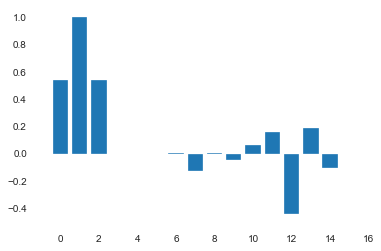

['PRIM_CONTRIBUTORY_CAUSE', 'CRASH_TYPE', 'FIRST_CRASH_TYPE', 'NUM_UNITS', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'Contributory_Cause_New', 'Posted_Speed_New', 'Traffic_Control_New', 'Weather_New', 'Road_Surface_New', 'Most_Severe_Injury_New', 'SEX2', 'BAC2', 'AGE2']


In [7]:
mt.feature_importance_lr(X, y)

## Feature importance using Random Forest

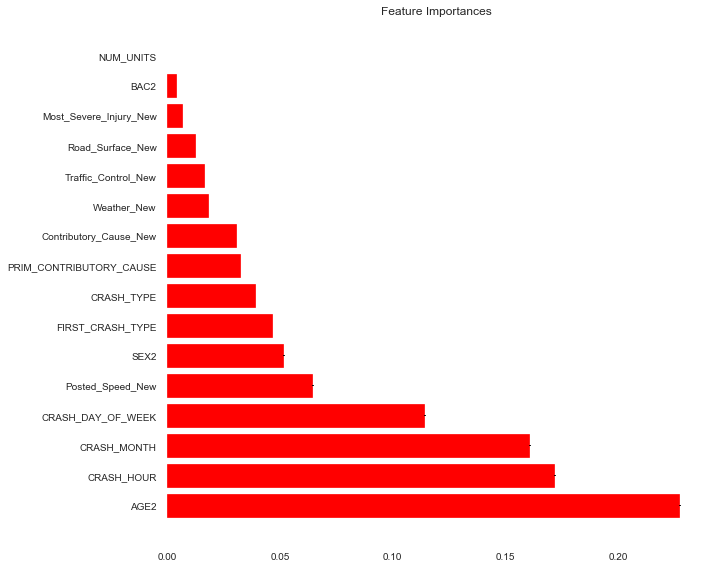

In [8]:
mt.feature_importance(X, y)

# CatBoost

## Split dataset in training and test without encoding to use CatBoost Estimator
- This estimator accepts accepts categorical features and can not be encoded 

In [6]:
#NOT ENCODED - NO RESAMPLED - CATBOOST
target = 'DAMAGE' #'Most_Severe_Injury_New'#'CRASH_TYPE'# 'CRASH_TYPE' # 'DAMAGE'
X, y, X_train, X_test, y_train, y_test, categorical_features_indices = mt.split_data(df, target=target)

PRIM_CONTRIBUTORY_CAUSE     object
FIRST_CRASH_TYPE            object
NUM_UNITS                    int64
CRASH_HOUR                   int64
CRASH_DAY_OF_WEEK            int64
CRASH_MONTH                  int64
Contributory_Cause_New      object
Posted_Speed_New           float64
Traffic_Control_New         object
Weather_New                 object
Road_Surface_New            object
SEX2                        object
BAC2                       float64
AGE2                       float64
dtype: object


## CatBoost Estimator NO Resampled
- Check the results without resampling classes

In [ ]:
model, cv_data = mt.model_catboost(X, y, X_train, y_train, X_test, y_test, categorical_features_indices, target=target, file= "catboost_accidents_predictionNOsampled.csv" )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4037655	test: 0.4009743	best: 0.4009743 (0)	total: 2.61s	remaining: 43m 24s
50:	learn: 0.3973734	test: 0.3949113	best: 0.4009743 (0)	total: 51.6s	remaining: 15m 59s
100:	learn: 0.4062602	test: 0.4039303	best: 0.4039303 (100)	total: 1m 50s	remaining: 16m 19s
150:	learn: 0.4110682	test: 0.4089309	best: 0.4089309 (150)	total: 3m 4s	remaining: 17m 17s
200:	learn: 0.4155140	test: 0.4133113	best: 0.4133565 (196)	total: 4m 18s	remaining: 17m 8s
250:	learn: 0.4173560	test: 0.4149433	best: 0.4149433 (250)	total: 5m 58s	remaining: 17m 49s
300:	learn: 0.4184178	test: 0.4157117	best: 0.4157117 (300)	total: 7m 38s	remaining: 17m 45s
350:	learn: 0.4198642	test: 0.4167252	best: 0.4167840 (347)	total: 8m 58s	remaining: 16m 34s
400:	learn: 0.4213672	test: 0.4181198	best: 0.4181697 (396)	total: 10m 47s	remaining: 16m 7s
450:	learn: 0.4231474	test: 0.4196634	best: 0.4197195 (447)	total: 12m 38s	remaining: 15m 22s
500:	learn: 0.4252050	test: 0.4218887	best: 0.4218955 (492)	total: 14m 46s	remai

In [ ]:
print('the best cv accuracy is :{}'.format(np.max(cv_data)))

In [ ]:
model = CatBoostClassifier(iterations=50, random_seed=42, logging_level='Silent').fit(train_pool)
validate_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)
eval_metrics = model.eval_metrics(validate_pool, ['TotalF1'], plot=True)

## CatBoost Estimator Oversampled DAMAGE
- Since the label/target is imbalanced, verify if there is an improvement in the model by balancing the classes.
- Process:
    - Oversample
    - Training

In [8]:
#NOT ENCODED - OVERSAMPLED - CATBOOST
# X, y, X_train, X_validation, y_train, y_validation, categorical_features_indices = ad.split_data(df, target="Disb Class")
X_train_res, y_train_res = mt.oversampling_cat(X_train, y_train)
model = mt.model_catboost(X_train_res, y_train_res, X_test, y_test, categorical_features_indices, target=target, file= "catboost_accidents_predictionSampled.csv" )

Resampled dataset shape Counter({'OVER $1,500': 129814, '$500 OR LESS': 129814, '$501 - $1,500': 129814})


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3935288	test: 0.3912182	test1: 0.4111389	best: 0.4111389 (0)	total: 2.38s	remaining: 39m 41s
50:	learn: 0.4067520	test: 0.4120848	test1: 0.3823526	best: 0.4111389 (0)	total: 1m 17s	remaining: 23m 53s
100:	learn: 0.4576251	test: 0.4763697	test1: 0.4054206	best: 0.4111389 (0)	total: 2m 58s	remaining: 26m 30s
150:	learn: 0.4744507	test: 0.5009691	test1: 0.4181902	best: 0.4181902 (150)	total: 4m 43s	remaining: 26m 34s
200:	learn: 0.4854052	test: 0.5181651	test1: 0.4219176	best: 0.4221743 (194)	total: 6m 21s	remaining: 25m 17s
250:	learn: 0.4954157	test: 0.5324735	test1: 0.4230475	best: 0.4235031 (247)	total: 8m 2s	remaining: 24m 1s
300:	learn: 0.5024923	test: 0.5430993	test1: 0.4226774	best: 0.4238080 (256)	total: 9m 45s	remaining: 22m 40s
350:	learn: 0.5077062	test: 0.5513491	test1: 0.4231558	best: 0.4238080 (256)	total: 11m 30s	remaining: 21m 17s
400:	learn: 0.5114832	test: 0.5570822	test1: 0.4243598	best: 0.4244006 (397)	total: 13m 14s	remaining: 19m 47s
450:	learn: 0.515337

## Get feature importance using catboost

In [9]:
#Get feature importance using catboost
model.get_feature_importance(prettified=True)

Feature Id  Importances
0                CRASH_HOUR    20.891962
1               CRASH_MONTH    15.096567
2          FIRST_CRASH_TYPE    14.034356
3    Contributory_Cause_New    13.075493
4         CRASH_DAY_OF_WEEK    10.296213
5   PRIM_CONTRIBUTORY_CAUSE     9.685135
6                      SEX2     4.564226
7       Traffic_Control_New     3.265376
8               Weather_New     3.264732
9          Posted_Speed_New     2.401106
10                     AGE2     1.690228
11         Road_Surface_New     1.582313
12                     BAC2     0.152293
13                NUM_UNITS     0.000000

## CatBoost Estimator Oversampled CRASH_TYPE

In [7]:
X_train_res, y_train_res = mt.oversampling_cat(X_train, y_train)
model = mt.model_catboost(X_train_res, y_train_res, X_test, y_test, categorical_features_indices, target=target, file= "catboost_accidents_predictionSampled_CT.csv" )

Resampled dataset shape Counter({'NO INJURY / DRIVE AWAY': 193881, 'INJURY AND / OR TOW DUE TO CRASH': 193881})


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6664878	test: 0.6661544	test1: 0.7164977	best: 0.7164977 (0)	total: 1.25s	remaining: 20m 45s
50:	learn: 0.6798965	test: 0.6804114	test1: 0.7475019	best: 0.7524874 (12)	total: 40.2s	remaining: 12m 27s
100:	learn: 0.6897672	test: 0.6919991	test1: 0.7480824	best: 0.7524874 (12)	total: 1m 38s	remaining: 14m 36s
150:	learn: 0.7037158	test: 0.7115801	test1: 0.7499977	best: 0.7524874 (12)	total: 2m 42s	remaining: 15m 15s
200:	learn: 0.7137018	test: 0.7252622	test1: 0.7512247	best: 0.7524874 (12)	total: 3m 48s	remaining: 15m 8s
250:	learn: 0.7225184	test: 0.7379060	test1: 0.7528727	best: 0.7529172 (249)	total: 4m 57s	remaining: 14m 46s
300:	learn: 0.7292603	test: 0.7482310	test1: 0.7532201	best: 0.7532201 (300)	total: 6m 15s	remaining: 14m 31s
350:	learn: 0.7378441	test: 0.7615039	test1: 0.7513218	best: 0.7532395 (308)	total: 7m 24s	remaining: 13m 41s
400:	learn: 0.7439381	test: 0.7715988	test1: 0.7508391	best: 0.7532395 (308)	total: 8m 28s	remaining: 12m 39s
450:	learn: 0.7469919	

In [8]:
#Get feature importance using catboost
model.get_feature_importance(prettified=True)

Feature Id  Importances
0    Contributory_Cause_New    22.332751
1          FIRST_CRASH_TYPE    18.651696
2                CRASH_HOUR    15.696816
3   PRIM_CONTRIBUTORY_CAUSE    11.521190
4               CRASH_MONTH     8.245177
5         CRASH_DAY_OF_WEEK     6.790988
6       Traffic_Control_New     5.133810
7          Posted_Speed_New     4.318950
8               Weather_New     3.060780
9                      AGE2     1.750563
10                     SEX2     1.337754
11         Road_Surface_New     0.944738
12                     BAC2     0.214787
13                NUM_UNITS     0.000000

## CatBoost Estimator Oversampled MOST_SEVERE_INJURY

In [7]:
X_train_res, y_train_res = mt.oversampling_cat(X_train, y_train)
model = mt.model_catboost(X_train_res, y_train_res, X_test, y_test, categorical_features_indices, target=target, file= "catboost_accidents_predictionSampled_MSI.csv" )

Resampled dataset shape Counter({'NO INDICATION OF INJURY': 214348, 'NONINCAPACITATING INJURY': 214348, 'INCAPACITATING OR FATAL': 214348})


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5040973	test: 0.5043427	test1: 0.6876402	best: 0.6876402 (0)	total: 4.14s	remaining: 1h 9m 1s
50:	learn: 0.7519017	test: 0.7590427	test1: 0.7292097	best: 0.7292097 (50)	total: 3m 8s	remaining: 58m 34s
100:	learn: 0.8013891	test: 0.8148718	test1: 0.7395620	best: 0.7395620 (100)	total: 6m 41s	remaining: 59m 29s
150:	learn: 0.8170041	test: 0.8310181	test1: 0.7525969	best: 0.7525969 (150)	total: 10m 26s	remaining: 58m 40s
200:	learn: 0.8290780	test: 0.8442459	test1: 0.7601783	best: 0.7601783 (200)	total: 13m 41s	remaining: 54m 23s
250:	learn: 0.8391038	test: 0.8547674	test1: 0.7660350	best: 0.7660350 (250)	total: 16m 55s	remaining: 50m 30s
300:	learn: 0.8475530	test: 0.8638450	test1: 0.7729736	best: 0.7729736 (300)	total: 20m 10s	remaining: 46m 51s
350:	learn: 0.8528421	test: 0.8698044	test1: 0.7768862	best: 0.7768862 (350)	total: 23m 29s	remaining: 43m 25s
400:	learn: 0.8571882	test: 0.8746753	test1: 0.7812188	best: 0.7812188 (400)	total: 26m 59s	remaining: 40m 18s
450:	learn:

In [8]:
#Get feature importance using catboost
model.get_feature_importance(prettified=True)

Feature Id  Importances
0                CRASH_HOUR    21.559322
1               CRASH_MONTH    19.068355
2    Contributory_Cause_New    14.837383
3         CRASH_DAY_OF_WEEK    11.929241
4          FIRST_CRASH_TYPE     9.288522
5                    DAMAGE     5.191874
6                      SEX2     4.314190
7       Traffic_Control_New     4.145315
8   PRIM_CONTRIBUTORY_CAUSE     3.379038
9               Weather_New     2.480685
10                     AGE2     1.559731
11         Road_Surface_New     1.150451
12         Posted_Speed_New     0.797284
13                     BAC2     0.298609
14                NUM_UNITS     0.000000

In [10]:

import warnings
warnings.filterwarnings('ignore')

#Split data
df1 = df.drop(['CRASH_TYPE', 'Most_Severe_Injury_New' ], axis =1)
X, y, X_train, X_test, y_train, y_test, categorical_features_indices = mt.split_data(df1, target='DAMAGE')


CRASH_DATE                category
FIRST_CRASH_TYPE          category
CRASH_HOUR                   int64
CRASH_DAY_OF_WEEK            int64
CRASH_MONTH                  int64
Contributory_Cause_New    category
Posted_Speed_New           float64
Traffic_Control_New       category
Weather_New               category
Road_Surface_New          category
SEX2                      category
BAC2                       float64
AGE2                       float64
dtype: object


In [ ]:
#####SHALLOW CLASSIFIERS
df1 = df1.drop(['LATITUDE', 'LONGITUDE', 'PRIM_CONTRIBUTORY_CAUSE', 'NUM_UNITS'], axis=1)
# without oversampling
mt.classifiers2( X_train, X_test, y_train, y_test, df1, target='DAMAGE')

In [ ]:
#shallow models undersampled 
df1 = df1.drop(['LATITUDE', 'LONGITUDE', 'PRIM_CONTRIBUTORY_CAUSE', 'NUM_UNITS'], axis=1)
x_train_under, y_train_under = mt.oversampling(X_train, X_test, y_train, y_test)
mt.classifiers2( x_train_under, X_test, y_train_under, y_test, df1, target='DAMAGE')

[[0.40336900969733486, {'clf__C': 100, 'clf__multi_class': 'ovr', 'clf__solver': 'saga'}, Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                       

In [7]:
import warnings
warnings.filterwarnings('ignore')
df1 = df1.drop(['LATITUDE', 'LONGITUDE', 'PRIM_CONTRIBUTORY_CAUSE', 'NUM_UNITS'], axis=1)
#oversampled
x_train_under, y_train_under = mt.oversampling(X_train, X_test, y_train, y_test)
mt.classifiers( x_train_under, X_test, y_train_under, y_test, df1, target='DAMAGE') 
# without oversampling
# mt.classifiers( X_train, X_test, y_train, y_test, df1, target='DAMAGE') 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')


KeyboardInterrupt: 

In [6]:
df = mt.data_imputation(df)
df.isnull().sum()

CRASH_DATE                    0
PRIM_CONTRIBUTORY_CAUSE       0
CRASH_TYPE                    0
FIRST_CRASH_TYPE              0
DAMAGE                        0
NUM_UNITS                     0
CRASH_HOUR                    0
CRASH_DAY_OF_WEEK             0
CRASH_MONTH                   0
LATITUDE                   1826
LONGITUDE                  1826
Contributory_Cause_New        0
Posted_Speed_New              0
Traffic_Control_New           0
Weather_New                   0
Road_Surface_New              0
Most_Severe_Injury_New        0
SEX2                          0
BAC2                          0
AGE2                          0
dtype: int64

In [7]:
#Split data
df1 = df.drop(['CRASH_TYPE', 'Most_Severe_Injury_New' ], axis =1)
X, y, X_train, X_test, y_train, y_test, categorical_features_indices = mt.split_data(df, target='DAMAGE')

CRASH_DATE                category
CRASH_TYPE                category
FIRST_CRASH_TYPE          category
CRASH_HOUR                   int64
CRASH_DAY_OF_WEEK            int64
CRASH_MONTH                  int64
Contributory_Cause_New    category
Posted_Speed_New           float64
Traffic_Control_New       category
Weather_New               category
Road_Surface_New          category
Most_Severe_Injury_New    category
SEX2                      category
BAC2                       float64
AGE2                       float64
dtype: object


In [13]:



# # # import the Random Under Sampler object.
# # from imblearn.under_sampling import RandomUnderSampler

# # # create the object.
# # under_sampler = RandomUnderSampler()

# # # fit the object to the training data.
# # x_train_under, y_train_under = under_sampler.fit_sample(X_train, y_train)

# # import the Random Over Sampler object.
# from imblearn.over_sampling import RandomOverSampler

# # create the object.
# over_sampler = RandomOverSampler()

# # fit the object to the training data.
# x_train_under, y_train_under = over_sampler.fit_sample(X_train, y_train)




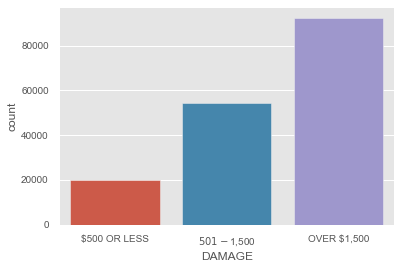

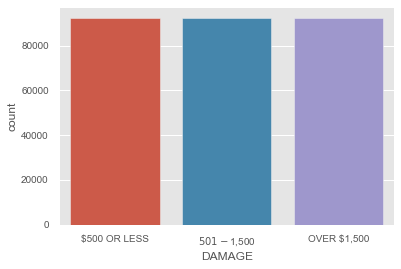

In [8]:
#**** CATBOOST DAMAGE WITHOUT OVERSAMPLING****

In [8]:
model = mt.model_catboost(X_train, y_train, X_test, y_test, categorical_features_indices )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3966990	test: 0.3966990	test1: 0.3966065	best: 0.3966065 (0)	total: 691ms	remaining: 11m 30s
50:	learn: 0.3966990	test: 0.3966990	test1: 0.3966065	best: 0.3966065 (0)	total: 43.1s	remaining: 13m 22s
100:	learn: 0.4056498	test: 0.4071965	test1: 0.4065664	best: 0.4065664 (100)	total: 1m 38s	remaining: 14m 36s
150:	learn: 0.4137926	test: 0.4138781	test1: 0.4131436	best: 0.4131436 (150)	total: 2m 53s	remaining: 16m 15s
200:	learn: 0.4189499	test: 0.4192974	test1: 0.4183522	best: 0.4183522 (200)	total: 4m 4s	remaining: 16m 10s
250:	learn: 0.4239105	test: 0.4241511	test1: 0.4225650	best: 0.4225650 (250)	total: 5m 19s	remaining: 15m 54s
300:	learn: 0.4277608	test: 0.4288268	test1: 0.4262583	best: 0.4262583 (300)	total: 6m 20s	remaining: 14m 42s
350:	learn: 0.4302780	test: 0.4331279	test1: 0.4282624	best: 0.4283187 (347)	total: 7m 18s	remaining: 13m 31s
400:	learn: 0.4332762	test: 0.4371047	test1: 0.4311287	best: 0.4311287 (400)	total: 8m 18s	remaining: 12m 25s
450:	learn: 0.435936

In [ ]:
#Feature importance according to Catboost
model.get_feature_importance(prettified=True)

Feature Id  Importances
0               CRASH_TYPE    29.323064
1         FIRST_CRASH_TYPE    13.271662
2   Contributory_Cause_New    11.463534
3               CRASH_HOUR     8.939119
4         Posted_Speed_New     5.950215
5                     AGE2     5.372686
6   Most_Severe_Injury_New     4.663396
7              CRASH_MONTH     4.608789
8        CRASH_DAY_OF_WEEK     3.672922
9      Traffic_Control_New     3.476454
10                    SEX2     3.225239
11             Weather_New     2.302296
12        Road_Surface_New     2.200618
13              CRASH_DATE     1.091905
14                    BAC2     0.438102

In [ ]:
#*****CATBOOST WITHOUT OVERSSAMPLING MOST SEVERITY************

In [9]:
#Split data
df1 = df.drop(['CRASH_TYPE', 'DAMAGE'], axis =1)
X, y, X_train, X_test, y_train, y_test, categorical_features_indices = mt.split_data(df1, target='Most_Severe_Injury_New')


CRASH_DATE                category
FIRST_CRASH_TYPE          category
CRASH_HOUR                   int64
CRASH_DAY_OF_WEEK            int64
CRASH_MONTH                  int64
Contributory_Cause_New    category
Posted_Speed_New           float64
Traffic_Control_New       category
Weather_New               category
Road_Surface_New          category
SEX2                      category
BAC2                       float64
AGE2                       float64
dtype: object


In [10]:
model = mt.model_catboost(X_train, y_train, X_test, y_test, categorical_features_indices)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8786429	test: 0.8785892	test1: 0.8794736	best: 0.8794736 (0)	total: 1.25s	remaining: 20m 44s
50:	learn: 0.8785892	test: 0.8785892	test1: 0.8794736	best: 0.8794736 (0)	total: 33.7s	remaining: 10m 26s
100:	learn: 0.8785892	test: 0.8785892	test1: 0.8794736	best: 0.8794736 (0)	total: 1m 8s	remaining: 10m 13s
150:	learn: 0.8785892	test: 0.8785892	test1: 0.8794736	best: 0.8794736 (0)	total: 1m 59s	remaining: 11m 12s
200:	learn: 0.8785892	test: 0.8785892	test1: 0.8794736	best: 0.8794736 (0)	total: 2m 56s	remaining: 11m 40s
250:	learn: 0.8785892	test: 0.8785892	test1: 0.8794736	best: 0.8794736 (0)	total: 3m 51s	remaining: 11m 31s
300:	learn: 0.8786383	test: 0.8786138	test1: 0.8794736	best: 0.8794736 (0)	total: 4m 44s	remaining: 11m
350:	learn: 0.8787560	test: 0.8786675	test1: 0.8795115	best: 0.8795136 (347)	total: 5m 37s	remaining: 10m 24s
400:	learn: 0.8787851	test: 0.8787356	test1: 0.8795216	best: 0.8795300 (379)	total: 6m 35s	remaining: 9m 50s
450:	learn: 0.8788632	test: 0.87882

In [11]:
#Feature importance according to Catboost
model.get_feature_importance(prettified=True)

Feature Id  Importances
0         FIRST_CRASH_TYPE    23.107124
1   Contributory_Cause_New    17.483528
2                     AGE2     9.021109
3               CRASH_HOUR     8.487585
4      Traffic_Control_New     7.540791
5         Posted_Speed_New     7.500457
6                     SEX2     5.983628
7              CRASH_MONTH     4.592728
8        CRASH_DAY_OF_WEEK     3.973274
9               CRASH_DATE     3.537377
10             Weather_New     3.296522
11        Road_Surface_New     2.898306
12                    BAC2     2.577569

In [ ]:
#*******CATBOOST WITOUTH OVERSAMPLING CRASH_TYPE****

In [12]:
#Split data
df2 = df.drop(['Most_Severe_Injury_New', 'DAMAGE'], axis =1)
X, y, X_train, X_test, y_train, y_test, categorical_features_indices = mt.split_data(df2, target='CRASH_TYPE')


CRASH_DATE                category
FIRST_CRASH_TYPE          category
CRASH_HOUR                   int64
CRASH_DAY_OF_WEEK            int64
CRASH_MONTH                  int64
Contributory_Cause_New    category
Posted_Speed_New           float64
Traffic_Control_New       category
Weather_New               category
Road_Surface_New          category
SEX2                      category
BAC2                       float64
AGE2                       float64
dtype: object


In [13]:
model = mt.model_catboost(X_train, y_train, X_test, y_test, categorical_features_indices)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7851961	test: 0.7865249	test1: 0.7858217	best: 0.7858217 (0)	total: 1.06s	remaining: 17m 36s
50:	learn: 0.7829819	test: 0.7852154	test1: 0.7866211	best: 0.7879884 (1)	total: 45.8s	remaining: 14m 12s
100:	learn: 0.7868241	test: 0.7886386	test1: 0.7903484	best: 0.7903484 (100)	total: 1m 36s	remaining: 14m 15s
150:	learn: 0.7903454	test: 0.7922952	test1: 0.7945787	best: 0.7945787 (150)	total: 2m 25s	remaining: 13m 40s
200:	learn: 0.7929050	test: 0.7952766	test1: 0.7972671	best: 0.7972671 (200)	total: 3m 13s	remaining: 12m 50s
250:	learn: 0.7946809	test: 0.7965724	test1: 0.7986506	best: 0.7986506 (250)	total: 3m 59s	remaining: 11m 55s
300:	learn: 0.7955362	test: 0.7977490	test1: 0.7994641	best: 0.7994641 (300)	total: 4m 45s	remaining: 11m 2s
350:	learn: 0.7964273	test: 0.7979521	test1: 0.7997766	best: 0.7998178 (348)	total: 5m 34s	remaining: 10m 17s
400:	learn: 0.7968059	test: 0.7989416	test1: 0.8001499	best: 0.8002006 (396)	total: 6m 20s	remaining: 9m 28s
450:	learn: 0.7975117

In [14]:
#Feature importance according to Catboost
model.get_feature_importance(prettified=True)

Feature Id  Importances
0   Contributory_Cause_New    22.098306
1         FIRST_CRASH_TYPE    20.460536
2         Posted_Speed_New    11.758063
3               CRASH_HOUR    11.032202
4      Traffic_Control_New     7.909451
5                     AGE2     7.100920
6               CRASH_DATE     4.003745
7              Weather_New     3.497941
8         Road_Surface_New     3.415454
9                     SEX2     2.995332
10             CRASH_MONTH     2.517702
11       CRASH_DAY_OF_WEEK     1.874208
12                    BAC2     1.336139

In [15]:
#******CATBOOST OVERSAMPLING DAMAGE****

CRASH_DATE                category
FIRST_CRASH_TYPE          category
CRASH_HOUR                   int64
CRASH_DAY_OF_WEEK            int64
CRASH_MONTH                  int64
Contributory_Cause_New    category
Posted_Speed_New           float64
Traffic_Control_New       category
Weather_New               category
Road_Surface_New          category
SEX2                      category
BAC2                       float64
AGE2                       float64
dtype: object


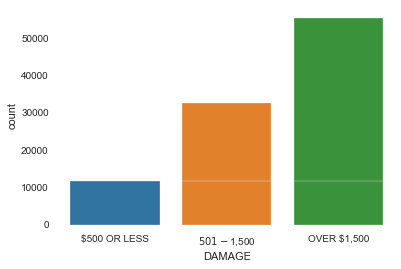

In [7]:
df1 = df.drop(['Most_Severe_Injury_New', 'CRASH_TYPE'], axis =1)
X, y, X_train, X_test, y_train, y_test, categorical_features_indices = mt.split_data(df1, target='DAMAGE')
x_train_under, y_train_under = mt.oversampling(X_train, X_test, y_train, y_test)
    
import seaborn as sns
sns.countplot(y_train)

sns.countplot(y_train_under)

In [8]:
model = mt.model_catboost(x_train_under, y_train_under, X_test, y_test, categorical_features_indices )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3973847	test: 0.4050998	test1: 0.3813942	best: 0.3813942 (0)	total: 1s	remaining: 16m 40s
50:	learn: 0.4014383	test: 0.4039631	test1: 0.3779399	best: 0.3837915 (1)	total: 34.2s	remaining: 10m 36s
100:	learn: 0.4131746	test: 0.4167046	test1: 0.4005062	best: 0.4005062 (100)	total: 1m 10s	remaining: 10m 26s
150:	learn: 0.4185890	test: 0.4213381	test1: 0.4061235	best: 0.4061435 (148)	total: 1m 45s	remaining: 9m 54s
200:	learn: 0.4228742	test: 0.4225355	test1: 0.4080963	best: 0.4082463 (199)	total: 2m 29s	remaining: 9m 53s
250:	learn: 0.4256713	test: 0.4293224	test1: 0.4107693	best: 0.4107693 (250)	total: 3m 7s	remaining: 9m 19s
300:	learn: 0.4293727	test: 0.4357530	test1: 0.4121944	best: 0.4123577 (295)	total: 3m 45s	remaining: 8m 43s
350:	learn: 0.4334893	test: 0.4393768	test1: 0.4128695	best: 0.4134224 (335)	total: 4m 24s	remaining: 8m 9s
400:	learn: 0.4383809	test: 0.4417966	test1: 0.4135167	best: 0.4137744 (392)	total: 5m 6s	remaining: 7m 38s
450:	learn: 0.4419047	test: 0.4

In [9]:
model.get_feature_importance(prettified=True)

Feature Id  Importances
0   Contributory_Cause_New    16.330165
1         FIRST_CRASH_TYPE    16.316989
2               CRASH_HOUR    13.986020
3              CRASH_MONTH     8.061284
4      Traffic_Control_New     7.514188
5                     AGE2     7.330985
6         Posted_Speed_New     7.194499
7        CRASH_DAY_OF_WEEK     6.962851
8                     SEX2     5.884134
9              Weather_New     4.392206
10        Road_Surface_New     4.325598
11              CRASH_DATE     0.928864
12                    BAC2     0.772217

In [ ]:
#CATBOOST RESAMPLING: Most_Severe_Injury_New

CRASH_DATE                category
FIRST_CRASH_TYPE          category
CRASH_HOUR                   int64
CRASH_DAY_OF_WEEK            int64
CRASH_MONTH                  int64
Contributory_Cause_New    category
Posted_Speed_New           float64
Traffic_Control_New       category
Weather_New               category
Road_Surface_New          category
SEX2                      category
BAC2                       float64
AGE2                       float64
dtype: object


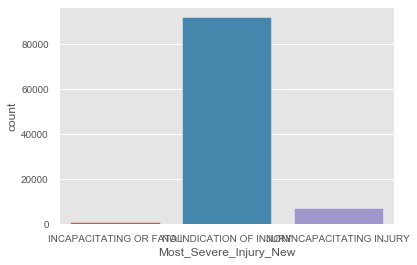

In [10]:
df2 = df.drop(['DAMAGE', 'CRASH_TYPE'], axis =1)
X, y, X_train, X_test, y_train, y_test, categorical_features_indices = mt.split_data(df2, target='Most_Severe_Injury_New')
x_train_under, y_train_under = mt.oversampling(X_train, X_test, y_train, y_test)
    
import seaborn as sns
sns.countplot(y_train)



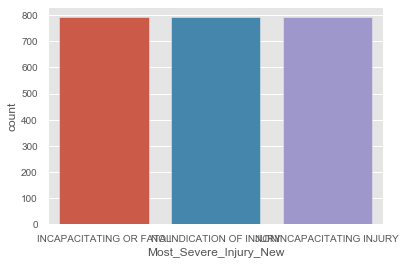

In [11]:
sns.countplot(y_train_under)

In [12]:
model = mt.model_catboost(x_train_under, y_train_under, X_test, y_test, categorical_features_indices )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3780485	test: 0.4603984	test1: 0.5808417	best: 0.5808417 (0)	total: 390ms	remaining: 6m 29s
50:	learn: 0.5251848	test: 0.5206139	test1: 0.6166609	best: 0.6183834 (47)	total: 17.9s	remaining: 5m 32s
100:	learn: 0.5590756	test: 0.5313167	test1: 0.6590315	best: 0.6595109 (99)	total: 36.7s	remaining: 5m 27s
150:	learn: 0.5813683	test: 0.5394027	test1: 0.6724412	best: 0.6724412 (150)	total: 59.8s	remaining: 5m 36s
200:	learn: 0.6120232	test: 0.5456251	test1: 0.6837083	best: 0.6839702 (199)	total: 1m 20s	remaining: 5m 18s
250:	learn: 0.6380274	test: 0.5407834	test1: 0.6931929	best: 0.6936908 (246)	total: 1m 41s	remaining: 5m 3s
300:	learn: 0.6627658	test: 0.5476149	test1: 0.6998111	best: 0.6998545 (299)	total: 2m 3s	remaining: 4m 45s
350:	learn: 0.6891986	test: 0.5575480	test1: 0.7024755	best: 0.7037967 (340)	total: 2m 26s	remaining: 4m 30s
400:	learn: 0.7170473	test: 0.5664418	test1: 0.7047816	best: 0.7050418 (399)	total: 2m 48s	remaining: 4m 11s
450:	learn: 0.7359999	test: 0.56

In [13]:
model.get_feature_importance(prettified=True)

Feature Id  Importances
0   Contributory_Cause_New    16.154139
1         FIRST_CRASH_TYPE    15.644096
2               CRASH_HOUR    14.517117
3              CRASH_MONTH    11.461851
4                     SEX2     8.323067
5                     AGE2     7.224489
6        CRASH_DAY_OF_WEEK     7.008230
7      Traffic_Control_New     6.661433
8              Weather_New     5.698732
9         Road_Surface_New     4.199173
10        Posted_Speed_New     2.713064
11                    BAC2     0.394609
12              CRASH_DATE     0.000000

In [14]:
#CATBOOST RESAMPLING: CRASH_TYPE

CRASH_DATE                category
FIRST_CRASH_TYPE          category
CRASH_HOUR                   int64
CRASH_DAY_OF_WEEK            int64
CRASH_MONTH                  int64
Contributory_Cause_New    category
Posted_Speed_New           float64
Traffic_Control_New       category
Weather_New               category
Road_Surface_New          category
SEX2                      category
BAC2                       float64
AGE2                       float64
dtype: object


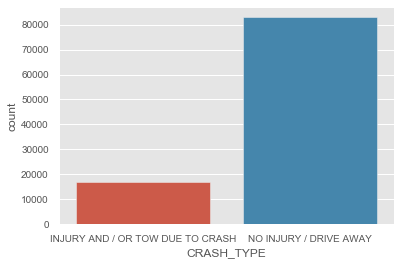

In [15]:
df3 = df.drop(['DAMAGE', 'Most_Severe_Injury_New'], axis =1)
X, y, X_train, X_test, y_train, y_test, categorical_features_indices = mt.split_data(df3, target='CRASH_TYPE')
x_train_under, y_train_under = mt.oversampling(X_train, X_test, y_train, y_test)
    
import seaborn as sns
sns.countplot(y_train)

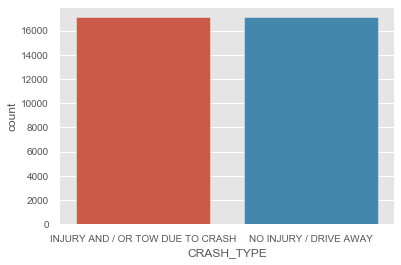

In [16]:
sns.countplot(y_train_under)

In [17]:
model = mt.model_catboost(x_train_under, y_train_under, X_test, y_test, categorical_features_indices )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6598591	test: 0.6665359	test1: 0.7666609	best: 0.7666609 (0)	total: 1.02s	remaining: 16m 55s
50:	learn: 0.6790044	test: 0.6840930	test1: 0.7371882	best: 0.7666609 (0)	total: 22.4s	remaining: 6m 57s
100:	learn: 0.6825016	test: 0.6871018	test1: 0.7392238	best: 0.7666609 (0)	total: 47.5s	remaining: 7m 2s
150:	learn: 0.6855903	test: 0.6890354	test1: 0.7383382	best: 0.7666609 (0)	total: 1m 17s	remaining: 7m 13s
200:	learn: 0.6873000	test: 0.6909651	test1: 0.7374158	best: 0.7666609 (0)	total: 1m 47s	remaining: 7m 7s
250:	learn: 0.6883333	test: 0.6913384	test1: 0.7372678	best: 0.7666609 (0)	total: 2m 17s	remaining: 6m 49s
300:	learn: 0.6889792	test: 0.6917480	test1: 0.7373310	best: 0.7666609 (0)	total: 2m 45s	remaining: 6m 23s
350:	learn: 0.6905393	test: 0.6922704	test1: 0.7373357	best: 0.7666609 (0)	total: 3m 14s	remaining: 5m 59s
400:	learn: 0.6916438	test: 0.6932144	test1: 0.7372354	best: 0.7666609 (0)	total: 3m 44s	remaining: 5m 36s
450:	learn: 0.6926710	test: 0.6938081	test1:

In [18]:
model.get_feature_importance(prettified=True)

Feature Id  Importances
0   Contributory_Cause_New    45.564630
1         FIRST_CRASH_TYPE    29.149779
2               CRASH_HOUR    18.108812
3      Traffic_Control_New     6.026192
4         Road_Surface_New     1.150587
5               CRASH_DATE     0.000000
6        CRASH_DAY_OF_WEEK     0.000000
7              CRASH_MONTH     0.000000
8         Posted_Speed_New     0.000000
9              Weather_New     0.000000
10                    SEX2     0.000000
11                    BAC2     0.000000
12                    AGE2     0.000000

In [ ]:
# -----------OTHER CLASSIFIERS -----------------------

In [8]:
df.columns

Index(['CRASH_DATE', 'PRIM_CONTRIBUTORY_CAUSE', 'CRASH_TYPE',
       'FIRST_CRASH_TYPE', 'DAMAGE', 'NUM_UNITS', 'CRASH_HOUR',
       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'LATITUDE', 'LONGITUDE',
       'Contributory_Cause_New', 'Posted_Speed_New', 'Traffic_Control_New',
       'Weather_New', 'Road_Surface_New', 'Most_Severe_Injury_New', 'SEX2',
       'BAC2', 'AGE2'],
      dtype='object')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# without oversampling
mt.classifiers( X_train, X_test, y_train, y_test, df, target='DAMAGE') 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')


In [10]:
#oversampled:  Most_Severe_Injury_New
df1 = df1.drop(['LATITUDE', 'LONGITUDE', 'PRIM_CONTRIBUTORY_CAUSE','NUM_UNITS', 'DAMAGE', 'Most_Severe_Injury_New'], axis=1)
mt.classifiers( x_train_under, X_test, y_train_under, y_test, df1, target='CRASH_TYPE')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
model score: 0.462
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
model score: 0.518
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split

In [12]:
df1.columns

Index(['CRASH_DATE', 'PRIM_CONTRIBUTORY_CAUSE', 'FIRST_CRASH_TYPE', 'DAMAGE',
       'NUM_UNITS', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LATITUDE', 'LONGITUDE', 'Contributory_Cause_New', 'Posted_Speed_New',
       'Traffic_Control_New', 'Weather_New', 'Road_Surface_New',
       'Most_Severe_Injury_New', 'SEX2', 'BAC2', 'AGE2'],
      dtype='object')

CRASH_DATE                category
CRASH_TYPE                category
FIRST_CRASH_TYPE          category
CRASH_HOUR                   int64
CRASH_DAY_OF_WEEK            int64
CRASH_MONTH                  int64
Contributory_Cause_New    category
Posted_Speed_New           float64
Traffic_Control_New       category
Weather_New               category
Road_Surface_New          category
Most_Severe_Injury_New    category
SEX2                      category
BAC2                       float64
AGE2                       float64
dtype: object


UnboundLocalError: local variable 'Pipeline' referenced before assignment

In [ ]:
#******************************************************

In [4]:
mt = Training()
df = mt.read_complete_data()
numerical_index, categorical_index=mt.identify_features(df)

In [5]:
categorical_index

Index(['TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION',
       'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE',
       'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'CRASH_TYPE',
       'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE',
       'STREET_DIRECTION', 'STREET_NAME', 'MOST_SEVERE_INJURY', 'PERSON_TYPE',
       'CRASH_DATE_y', 'STATE', 'SEX', 'AIRBAG_DEPLOYED', 'EJECTION',
       'INJURY_CLASSIFICATION', 'DRIVER_ACTION', 'DRIVER_VISION',
       'PHYSICAL_CONDITION', 'UNIT_TYPE', 'MAKE', 'VEHICLE_DEFECT',
       'VEHICLE_TYPE'],
      dtype='object')

In [6]:
# df = mt.encode(numerical_index, categorical_index, df)

In [7]:
categorical_index = categorical_index.drop(['DAMAGE'])

In [8]:
# df["STATE"].isna().any()

In [9]:
# df = mt.data_imputation(df)

In [10]:
# col_transform, df = mt.encode(numerical_index, categorical_index, df)

In [11]:
X, y, X_train, X_test, y_train, y_test, categorical_features_indices = mt.split_data(df)

POSTED_SPEED_LIMIT                  int64
TRAFFIC_CONTROL_DEVICE           category
DEVICE_CONDITION                 category
WEATHER_CONDITION                category
LIGHTING_CONDITION               category
FIRST_CRASH_TYPE                 category
TRAFFICWAY_TYPE                  category
ALIGNMENT                        category
ROADWAY_SURFACE_COND             category
ROAD_DEFECT                      category
CRASH_TYPE                       category
PRIM_CONTRIBUTORY_CAUSE          category
SEC_CONTRIBUTORY_CAUSE           category
STREET_NO                           int64
STREET_DIRECTION                 category
STREET_NAME                      category
NUM_UNITS                           int64
MOST_SEVERE_INJURY               category
INJURIES_TOTAL                      int64
INJURIES_FATAL                      int64
INJURIES_INCAPACITATING             int64
INJURIES_NON_INCAPACITATING         int64
INJURIES_REPORTED_NOT_EVIDENT       int64
INJURIES_NO_INDICATION            

In [62]:
 #encode starts
X_train_encoded = pd.get_dummies(X_train,columns=categorical_index, sparse=True)#vector encode
X_test_encoded = pd.get_dummies(X_test,columns=categorical_index, sparse=True)
y_train_encoded = y_train.factorize()#ordinal
y_test_encoded = y_test.factorize()
#encode ends

In [63]:
clfs, param_grids = mt.dict_classifiers()

In [64]:
pipe_clfs=mt.dict_pipeline(clfs, col_transform="")

[('StandardScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=0, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False))]


In [65]:
# param_grids = mt.params_lr(param_grids)
param_grids = mt.params_mlp(param_grids)
param_grids = mt.params_rf(param_grids)
param_grids = mt.params_xgboost(param_grids)
param_grids = mt.params_svc(param_grids)
param_grids = mt.params_knn(param_grids)
# param_grids = mt.params_catboost(param_grids)


In [66]:
param_grids

{'mlp': [{'clf__hidden_layer_sizes': [10, 100],
   'clf__activation': ['identity', 'logistic', 'tanh', 'relu']}],
 'rf': [{'clf__n_estimators': [10, 100],
   'clf__min_samples_split': [2, 10, 30],
   'clf__min_samples_leaf': [1, 10, 30]}],
 'xgb': [{'clf__eta': [0.0001, 0.001, 0.01, 0.1, 1],
   'clf__gamma': [0, 10, 100],
   'clf__lambda': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
 'svc': [{'clf__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
   'clf__gamma': ['auto', 'scale']}],
 'knn': [{'clf__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}]}

In [67]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
mt.classifiers( X_train, X_test, y_train, y_test, df)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
model score: 0.577


C:\Users\mariagi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [34]:
best_score_param_estimators = mt.hyperparameter_tunning(pipe_clfs, param_grids, X_train_encoded, y_train_encoded)

TypeError: estimator should be an estimator implementing 'fit' method, [('StandardScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False))] was passed

In [ ]:
mt.model_selection(best_score_param_estimators)

In [ ]:
profile.to_file("C:/Users/mariagi/Documents/Borrar/EDA4.html")